# Opening the Black Box

Now that we've got a working model, let's look underneath the hood and see what has been going on.  We're going to choose 2 specific images, a normal chest x-ray and one with pneumonia present, and visualize the activations at each layer.  This way we'll be able to see how the images are being transformed and, with any hope, discover what the model is using to distinguish between the two.

## Loading data

In [4]:
import warnings
warnings.filterwarnings('ignore')

import os, os.path
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import keras_preprocessing
from keras.preprocessing.image import ImageDataGenerator, image
from keras import layers, models

### Loading model

Let's go ahead and load our saved model. We tuned this model with the following methods:

* Each layer had initialized normal weights with the He_Normal kernel initializer
* The layers are all regularized using L2 Regularization
* We've also utilized Data Augmentation as another precaution against overfitting
* The model was optimized using Adam with the default learning rate of 0.001

In [14]:
from keras.models import load_model
model = load_model('chest_xray_augmented_regularized_data.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 64, 64, 128)       73856     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 256)       295168    
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 16, 16, 256)       0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 65536)             0         
__________

### Loading images

We're going to be loading the images with the highest resolutions.  That way, even with the image compression, we'll still have the highest amount of data per pixel.  In theory, this would allow our model to make the best predictions and give us a better chance of seeing what the model views as important information.

In [11]:
# Importing image files
normal_filename = '../chest_xray/test/NORMAL/IM-0045-0001.jpeg'
normal_img = image.load_img(normal_filename, target_size=(128, 128))

pneumonia_filename = '../chest_xray/test/PNEUMONIA/person34_virus_76.jpeg'
pneumonia_img = image.load_img(pneumonia_filename, target_size=(128, 128))

Normal


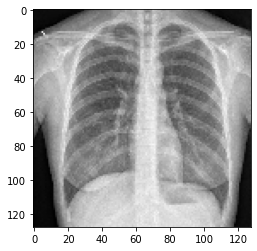

Pneumonia


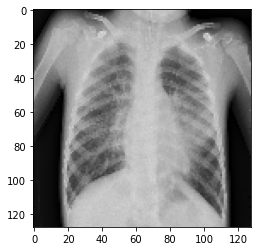

In [12]:
# Checking images
print('Normal')
plt.imshow(normal_img)
plt.show();
print('Pneumonia')
plt.imshow(pneumonia_img)
plt.show();

The images are still quite compressed, but we can still tell which is the pneumonia case, even if you don't look at the labels.

# Preprocessing Images

In order "see" what the model does, we'll need to transform them into tensors and then rescale them to the model's specifications (grayscale).

Normal Tensor Shape:  (1, 128, 128, 3)


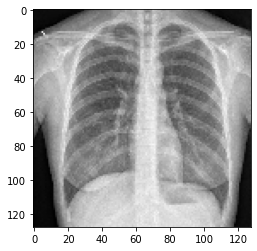

----------------------------------
Pneumonia Tensor Shape:  (1, 128, 128, 3)


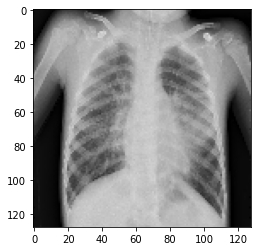

In [32]:
# Transforming images into tensors

# Normal
normal_tens = image.img_to_array(normal_img)
normal_tens = np.expand_dims(normal_tens, axis=0)

# Pneumonia
pneumonia_tens = image.img_to_array(pneumonia_img)
pneumonia_tens = np.expand_dims(pneumonia_tens, axis=0)

# Rescaling to model specs
normal_tens /= 255.
pneumonia_tens /= 255.

# Double checking the new shapes and image integrity
print('Normal Tensor Shape: ', normal_tens.shape)
plt.imshow(normal_tens[0])
plt.show();

print('----------------------------------')

print('Pneumonia Tensor Shape: ', pneumonia_tens.shape)
plt.imshow(pneumonia_tens[0])
plt.show();

Awesome! The tensors are the correct shape and the images haven't been altered!  We can now go about extracting the outputs of each of the layers. 

# Feature Mapping

Our next step is to extract the layer outputs from the model after activation.  We'll run the images through the model and extract the images at each activation.  This way we'll be able to "see" what the model is doing at each activation.

In [64]:
import math

def feature_maps(image_tensor):
    """
    Input an image tensor.
    
    Function will extract the model's layer outputs and create a model that 
    displays the feature maps.  It will then extract the layer names for 
    labeling during the plotting stage.  It will then plot the images in the 
    same way that the given provided model would at every layer of the 
    neural network. These transformed images will then be plotted for visual 
    inspection.
    """
    layer_names = []
    for layer in model.layers[:12]:
        layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot

    activations = activation_model.predict(image_tensor)    

    images_per_row = 16

    for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
        n_features = layer_activation.shape[-1] # Number of features in the feature map
        size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
        n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols): # Tiles each filter into a big horizontal grid
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size, # Displays the grid
                             row * size : (row + 1) * size] = channel_image
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')


MemoryError: Unable to allocate 2.00 PiB for an array with shape (268435456, 1048576) and data type float64

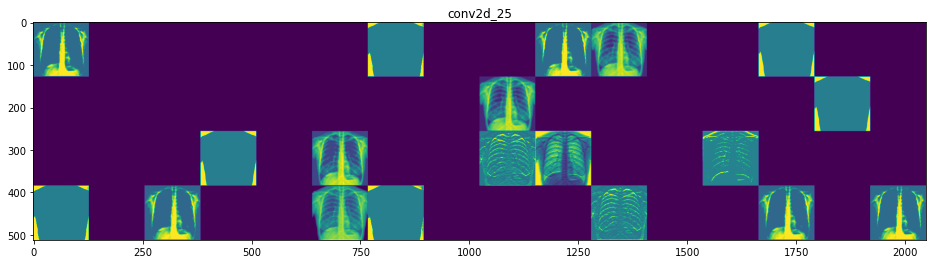

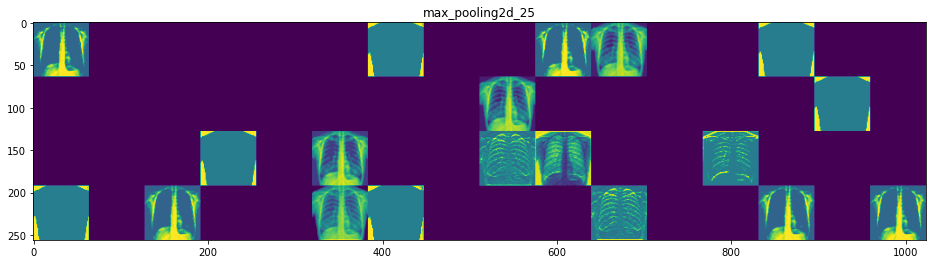

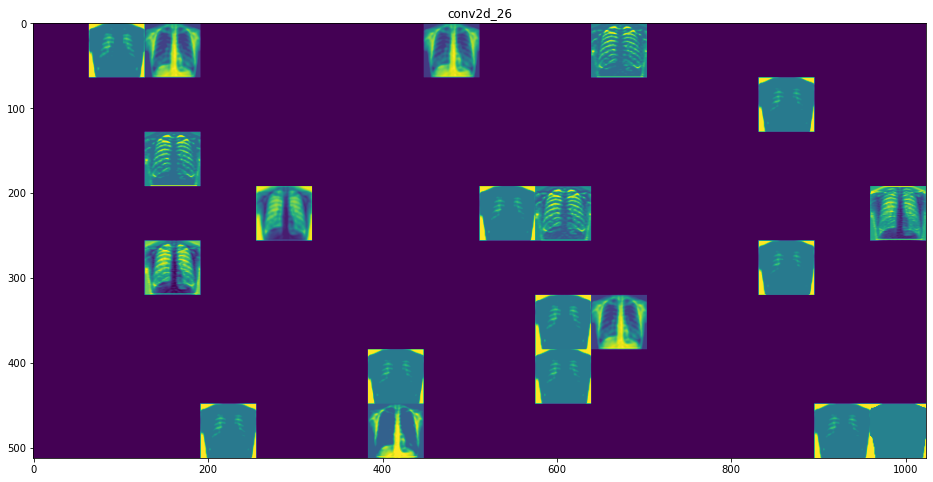

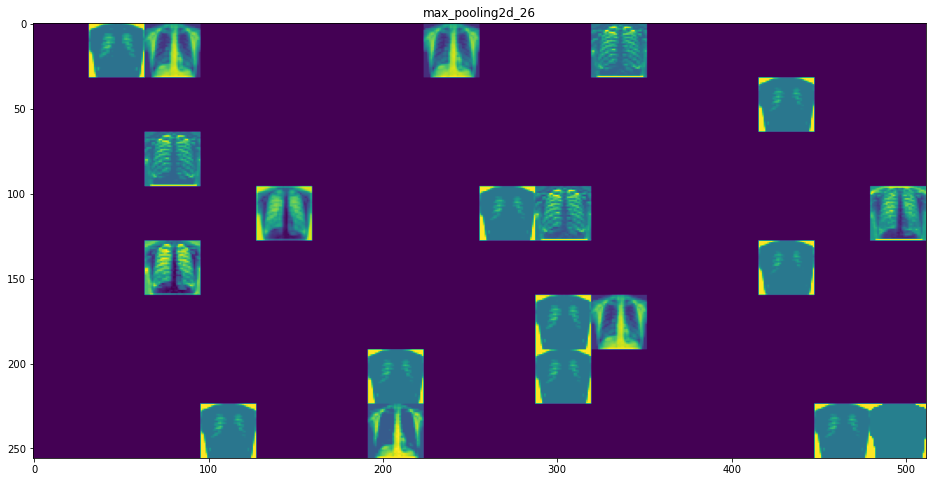

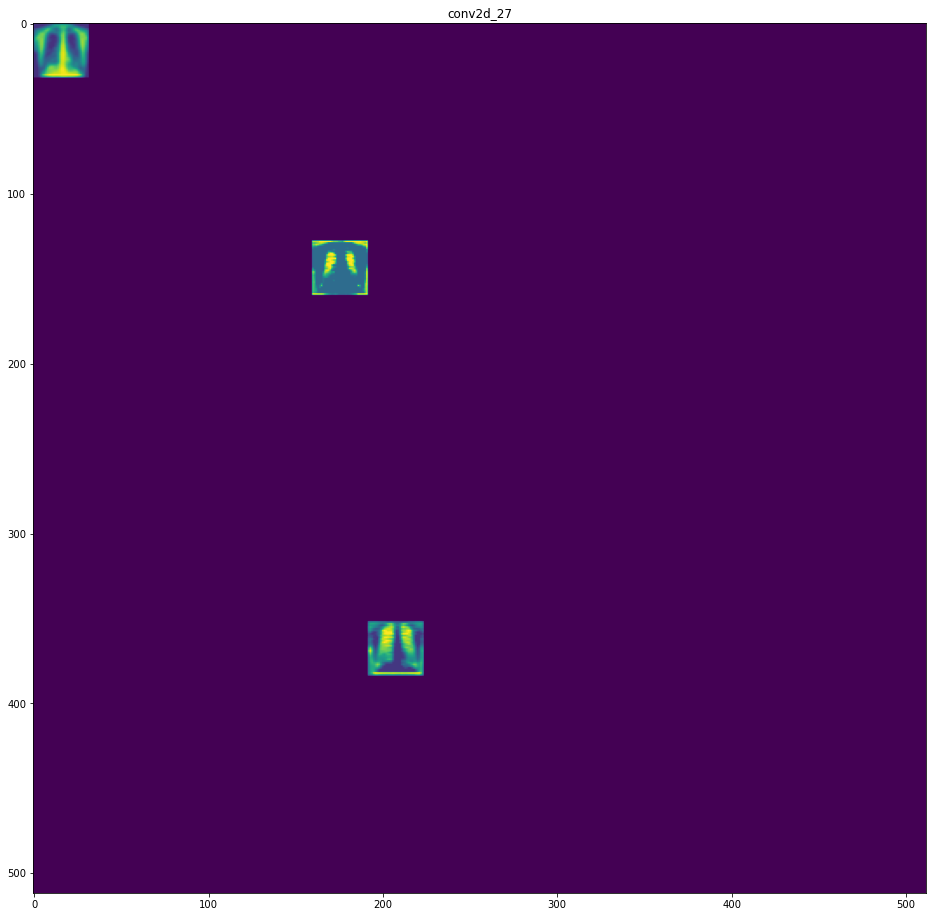

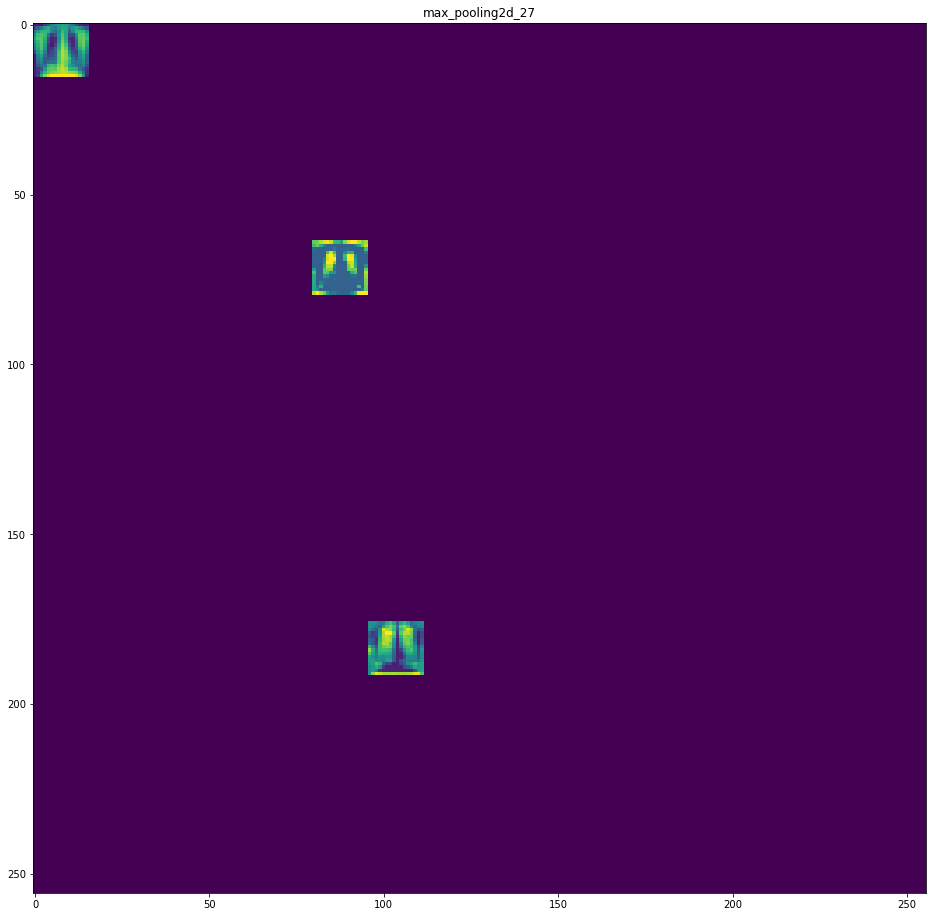

In [66]:
feature_maps(normal_tens)

MemoryError: Unable to allocate 2.00 PiB for an array with shape (268435456, 1048576) and data type float64

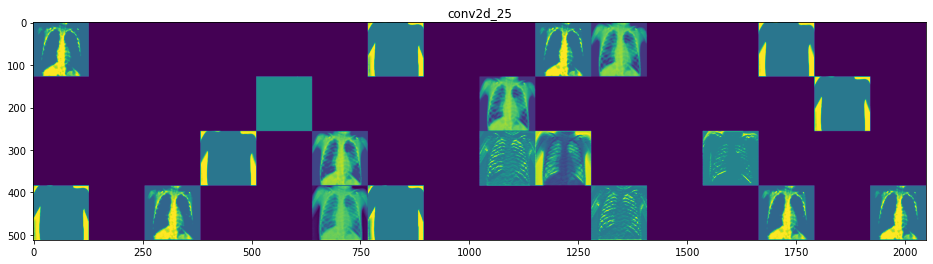

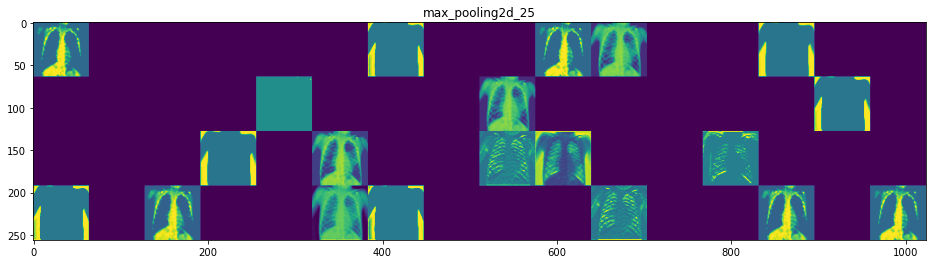

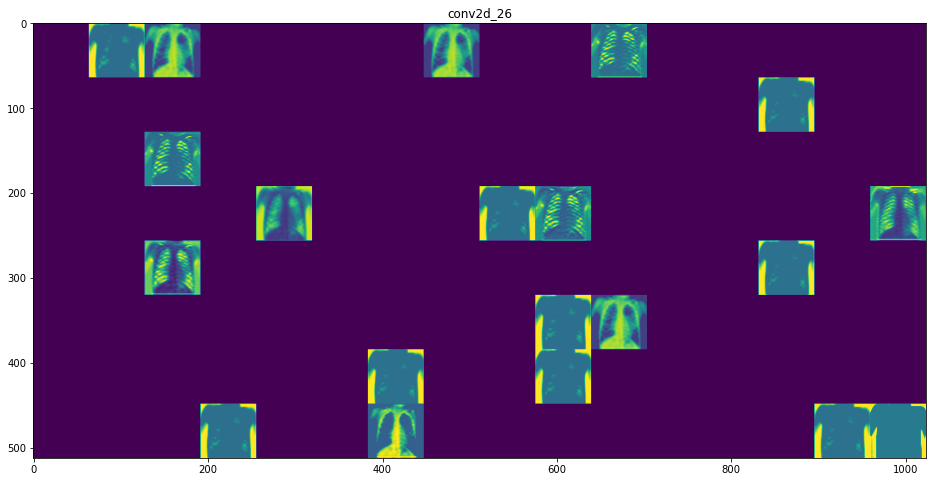

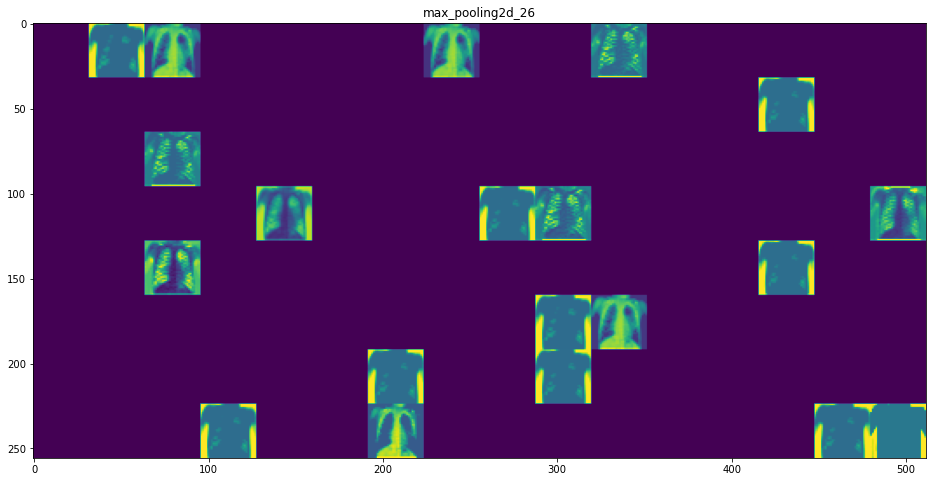

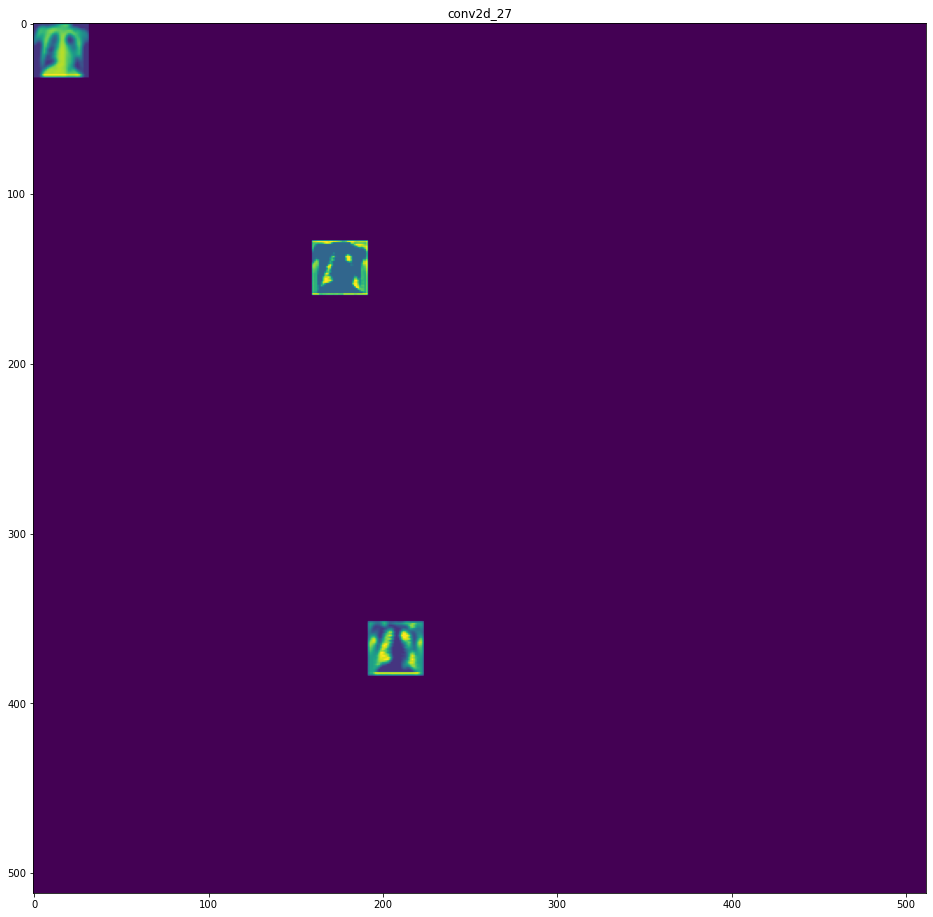

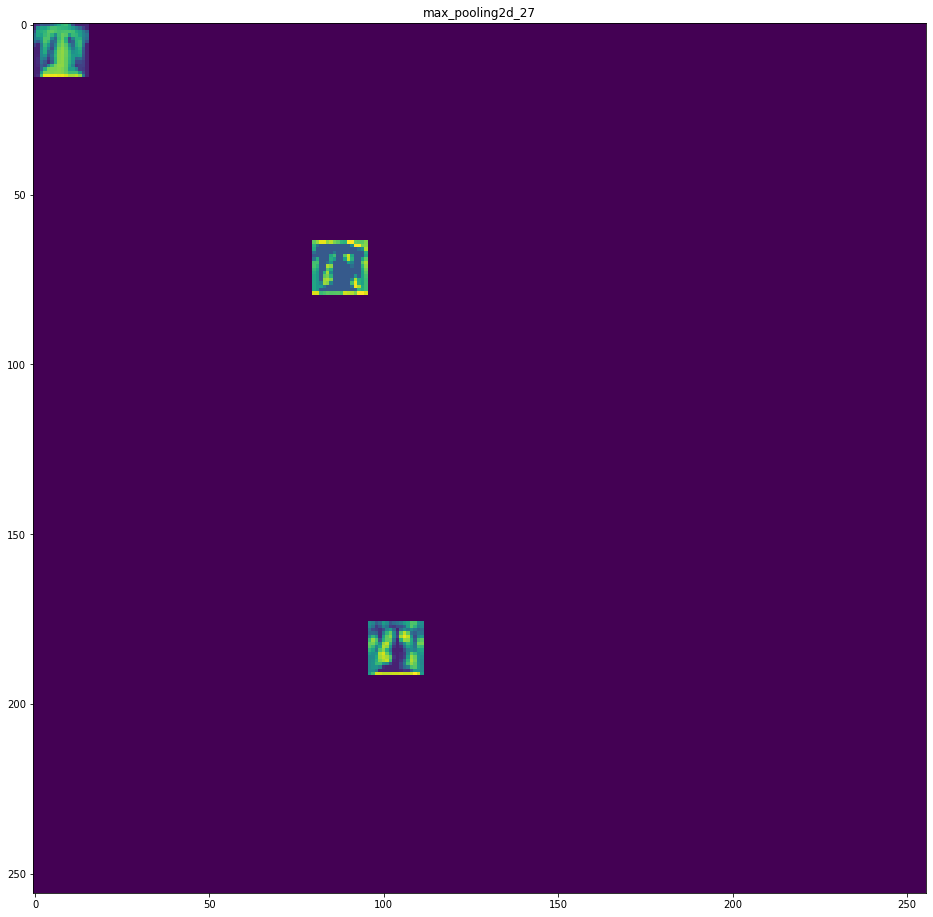

In [67]:
feature_maps(pneumonia_tens)

## Findings:

We can see that in addition to identifying general "cloudiness", the model inspects the separate levels of intensity so that it can, in essence, "peel away" layers of the image.  This allows it to filter out noise from skin silhouettes to actual bones.  

Why would you want to filter out this the rib cage if you're looking for cloudiness in the lungs?  Well, the noise created by the pneumonia will "bleed" into the background.  Essentially, the more concentrated noise present, the greater the general pixel intensity in all "layers" of the image, even in the background, causing what would look like deformations.

The model also cross-references this information by inverting the pixel intensities (essentially creating a "negative" of the image).  This really highlights the cloudiness in images, even in lower resolutions and serves as a cross-validation of sorts.